In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils

In [3]:
from pathlib import Path
current_working_directory = Path.cwd()

In [4]:
METRIC = 'execution_time'
SERVER = 'NUC'

In [5]:
DATAPATH = f"../experiments/{SERVER}_data.csv"

In [6]:
data = pd.read_csv(DATAPATH)

In [7]:
data[METRIC] = data[METRIC] / 60 

In [8]:
data[(data['subject'] == 'pypy') & (data['target'] == 'fasta')][METRIC]

65     0.309644
73     0.308382
75     0.308389
101    0.307081
108    0.308191
173    0.308436
303    0.307566
336    0.307402
415    0.307304
433    0.307208
497    0.309844
543    0.307182
590    0.310417
600    0.308002
602    0.307291
Name: execution_time, dtype: float64

In [9]:
subjects = list(set(data['subject'].values))
targets = ['mandelbrot', 'fannkuch_redux', 'binary_trees', 'n_body', 'spectralnorm', 'k_nucleotide', 'fasta']

GROUPS = list(
    product(subjects, targets)
)

In [10]:
data['subject'] = pd.Categorical(
    data['subject'],
    ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
)

In [11]:
data = data.dropna(subset=['execution_time'])

## Descriptive Statistics

### Descriptive Statistics per Benchmark

In [12]:
def reform(dictionary):
    return {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}

In [13]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)
    stats =  {'subject': subject, 'target' : target} | df[METRIC].describe().to_dict()
    descriptive.append(
        stats
    )

table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,target,count,mean,std,min,25%,50%,75%,max
31,codon,n_body,15.0,0.074656,0.001073,0.073492,0.073772,0.074350,0.075513,0.076702
34,codon,fasta,15.0,0.305160,0.001229,0.303644,0.304107,0.304844,0.306074,0.307636
33,codon,k_nucleotide,15.0,0.768898,0.001538,0.766197,0.767728,0.768869,0.769654,0.772067
32,codon,spectralnorm,15.0,0.065355,0.001736,0.063477,0.063933,0.064842,0.066538,0.069234
30,codon,binary_trees,15.0,0.368845,0.002065,0.367034,0.367453,0.367982,0.369857,0.373043
...,...,...,...,...,...,...,...,...,...,...
57,pyston-lite,fannkuch_redux,15.0,36.861285,0.053688,36.756929,36.851633,36.859424,36.864811,36.999451
58,pyston-lite,binary_trees,15.0,18.103916,0.047627,18.050996,18.070825,18.101947,18.118843,18.212025
59,pyston-lite,n_body,15.0,8.772158,0.294470,8.610596,8.633362,8.641928,8.708573,9.490470
60,pyston-lite,spectralnorm,15.0,7.544248,0.007964,7.536133,7.540292,7.542009,7.544093,7.562967


latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

### Aggregated Descriptive Statistics

In [14]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]
    stats = {'subject': subject} | df[METRIC].describe().to_dict()
    descriptive.append(stats)

table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,count,mean,std,min,25%,50%,75%,max
4,codon,105.0,0.563002,0.448936,0.063477,0.075608,0.367982,1.124393,1.235049
0,cpython,105.0,13.434082,10.729196,4.115707,4.446271,8.643957,18.057084,37.298606
6,cython,105.0,12.591958,8.197309,3.649038,4.558267,13.793703,15.588702,29.038427
7,mypyc,105.0,13.054308,11.216463,4.497021,5.233750,8.069184,15.495438,38.715314
1,nuitka,105.0,11.586458,8.199841,3.099023,3.713491,12.702949,15.128549,28.159650
2,numba,105.0,1.258877,0.956258,0.146944,0.500958,1.152922,1.577911,3.362900
5,py3.13-jit,105.0,10.519740,6.192007,4.879019,5.164325,8.655560,15.846662,23.167532
3,pypy,105.0,1.084087,0.695946,0.307081,0.317555,1.181889,1.895394,2.178779
8,pyston-lite,105.0,13.440681,10.707811,4.120931,4.450147,8.641928,18.070591,36.999451


latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

## BarPlots

In [15]:
colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

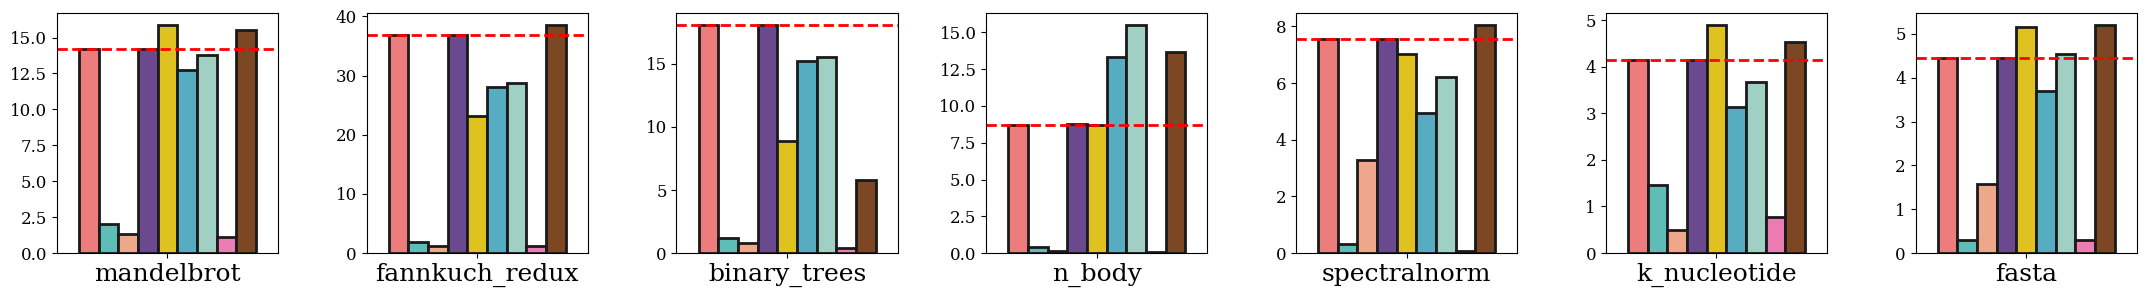

In [16]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df.sort_values(by=['subject'])
    sns.barplot(
        x="target", y=METRIC, hue="subject", capsize = 0.5, errorbar=None, edgecolor = '0.1', lw=2, data=df, ax = axs_flat[i], dodge=True,
        palette=colors
    )

    axs_flat[i].get_legend().remove()
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')
    axs_flat[i].tick_params(axis='x', labelsize=18)
    
    first_bar = axs_flat[i].patches[0]
    bar_height = first_bar.get_height()
    axs_flat[i].axhline(y=bar_height, color='red', linestyle='--', linewidth=2)
        
plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"{SERVER}_{METRIC}.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Normality

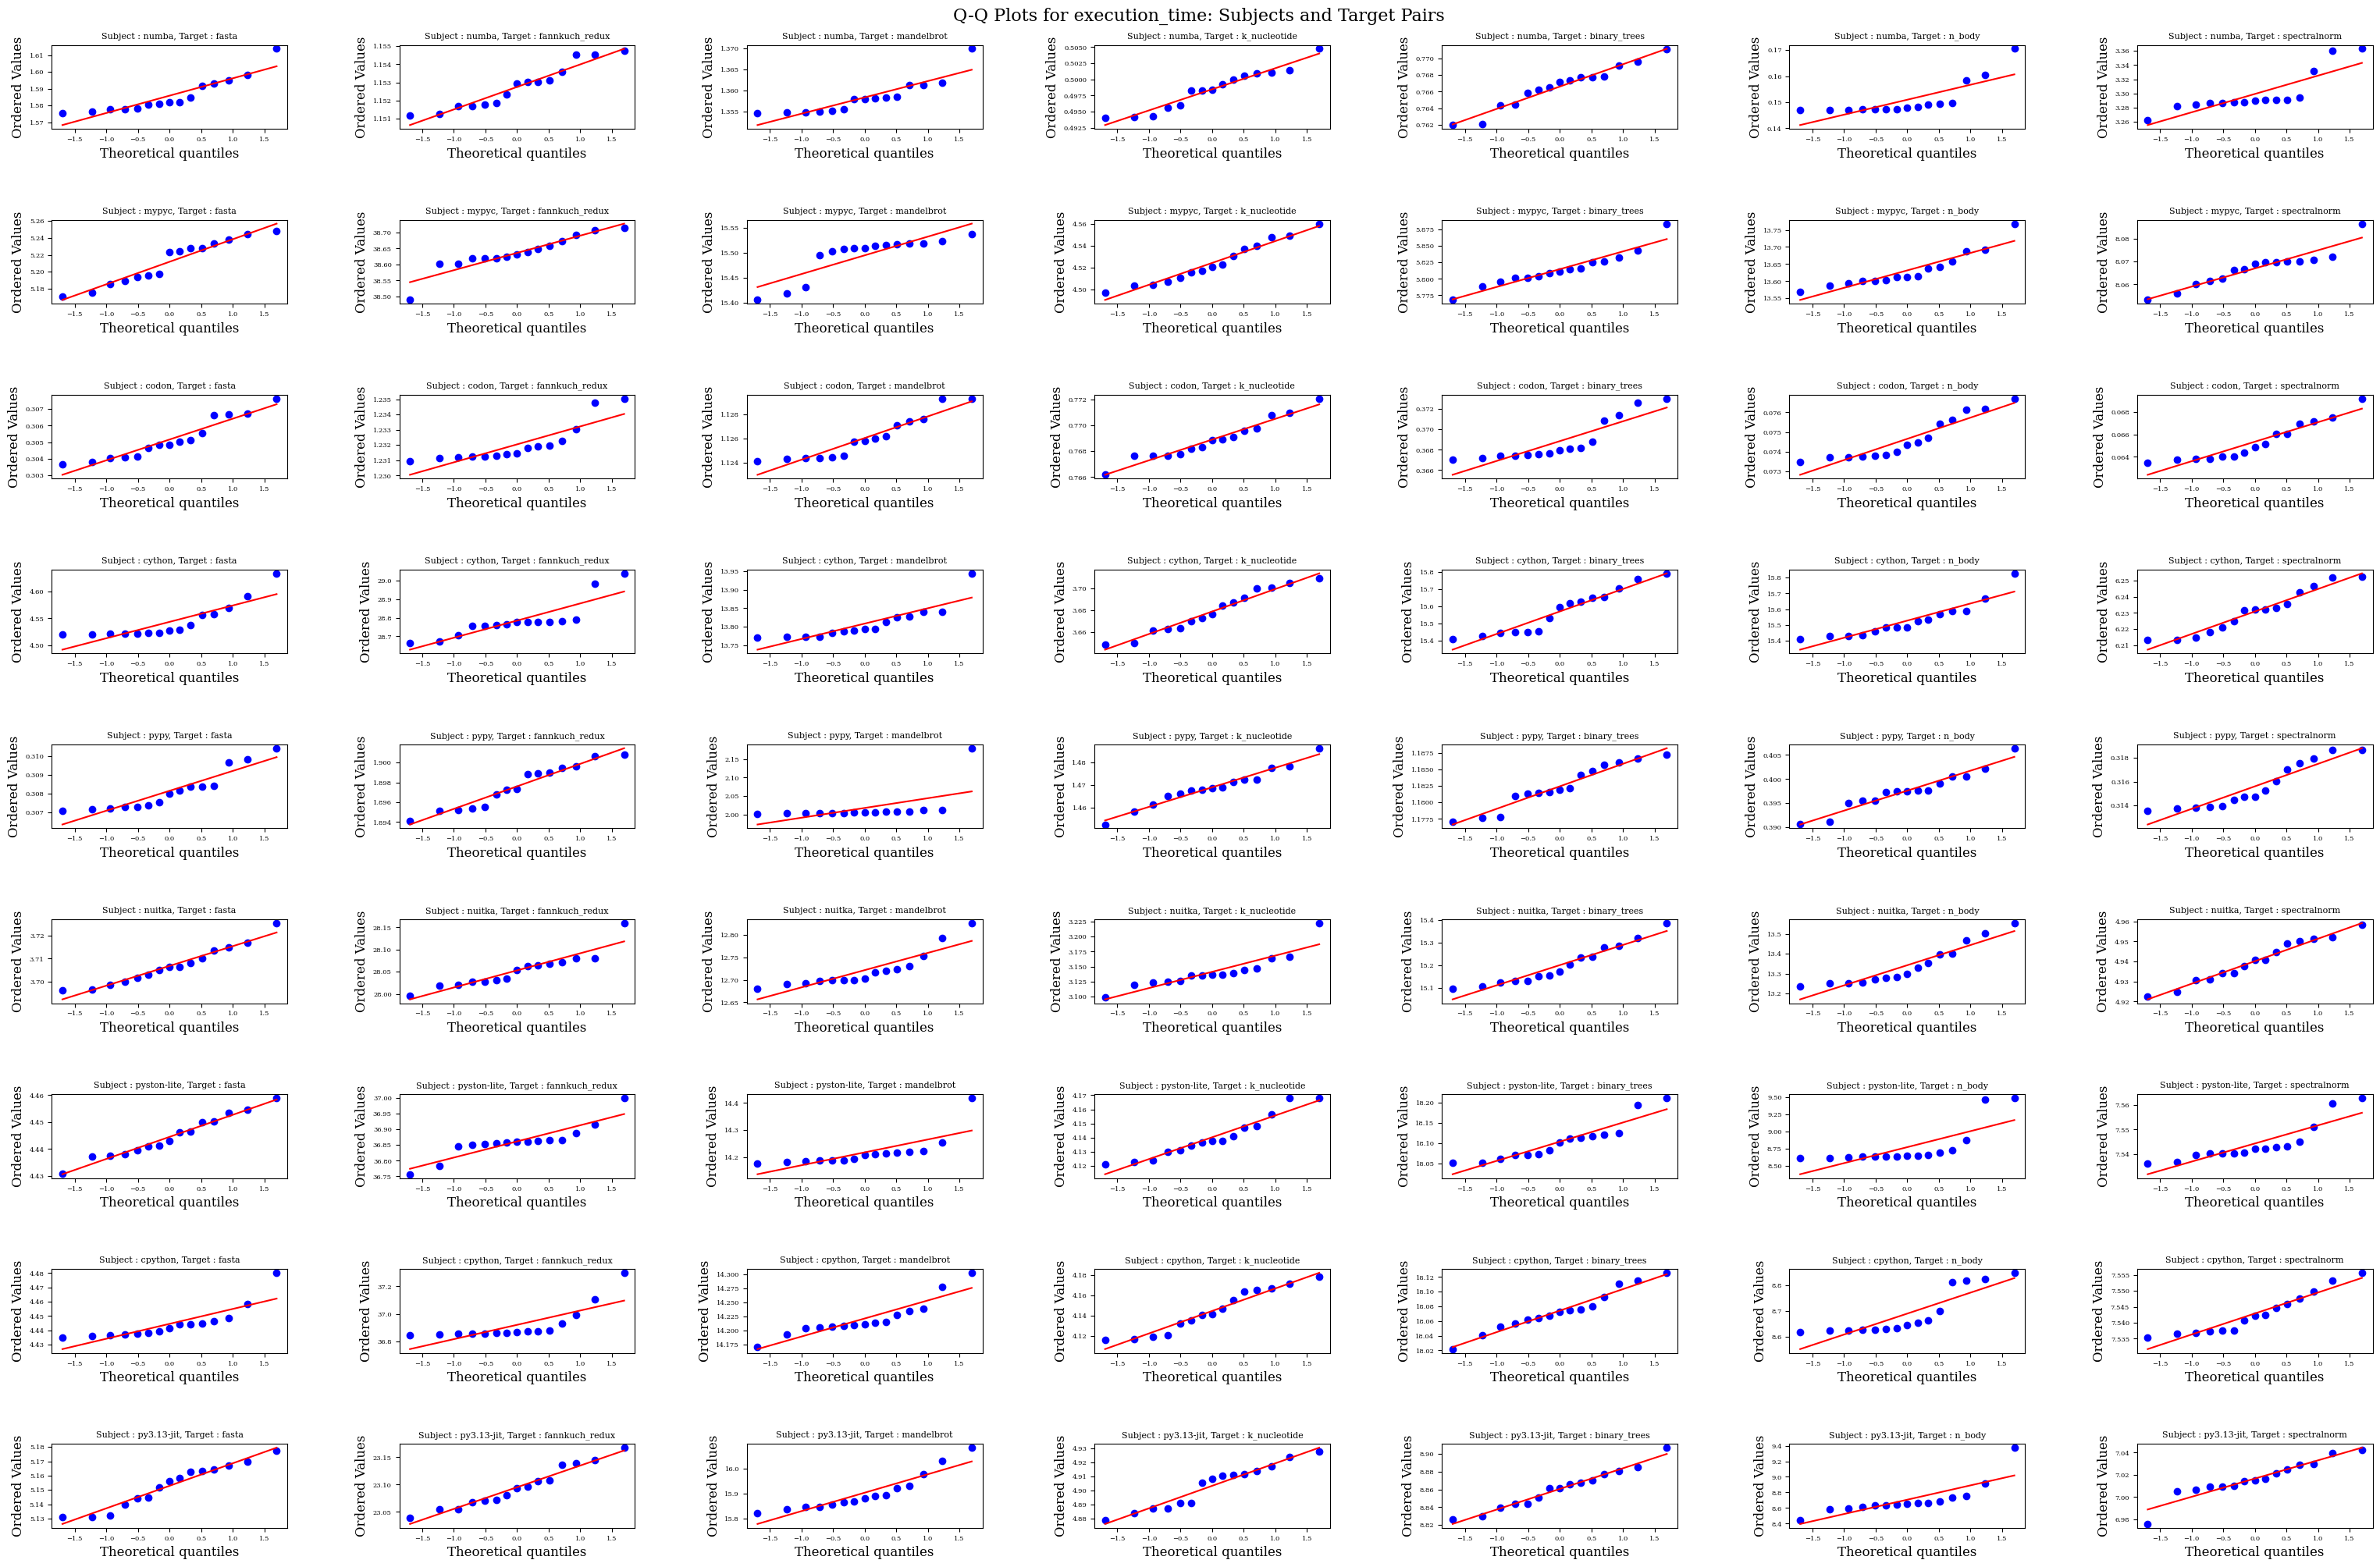

In [17]:
utils.plot_qq_grid(data, METRIC)

In [18]:
### Shapiro-Wilk Aggregated 

In [19]:
from scipy import stats

In [20]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject][METRIC]
    statistic, p_value = stats.shapiro(df)
    print(subject, p_value)

cpython 8.717328580506963e-12
nuitka 4.903298525962244e-10
numba 1.3687875701567877e-09
pypy 3.7595465795157655e-10
codon 1.6550616773138655e-09
py3.13-jit 2.8678752104390893e-11
cython 1.1153162923299337e-09
mypyc 1.595978294426414e-13
pyston-lite 9.386033783010543e-12


In [21]:
### Shapiro-Wilk per Benchmark

In [22]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)[METRIC]
    statistic, p_value = stats.shapiro(df)
    row = {'subject': subject, 'target' : target, 'p-value' : p_value, 'normal?' : 'normal' if p_value > 0.05 else 'maybe not'}
    descriptive.append(row)

pd.DataFrame(descriptive)

,subject,target,p-value,normal?
0,cpython,mandelbrot,0.028526,maybe not
1,cpython,fannkuch_redux,0.000038,maybe not
2,cpython,binary_trees,0.817868,normal
3,cpython,n_body,0.000632,maybe not
4,cpython,spectralnorm,0.132354,normal
...,...,...,...,...
58,pyston-lite,binary_trees,0.033850,maybe not
59,pyston-lite,n_body,0.000011,maybe not
60,pyston-lite,spectralnorm,0.001779,maybe not
61,pyston-lite,k_nucleotide,0.202758,normal


## Kruskal

In [23]:
from scipy.stats import kruskal

In [24]:
samples = []
for subject in subjects:
    df = data[data['subject'] == subject]['execution_time']
    samples.append(df.to_list())

stat, p_value = kruskal(*samples)
print({'stat': stat, 'p_value': p_value})

{'stat': 635.8011865530802, 'p_value': 4.6811667906516744e-132}


## Cliffs Delta

In [25]:
from cliffs_delta import cliffs_delta
import itertools

In [26]:
# Baseline - CPython Group
baseline = [utils.get_rows_by_subject_target(data, 'cpython', target)[METRIC].to_list() for target in targets]
baseline = list(itertools.chain(*baseline))

In [27]:
rows = []
for subject in subjects:
    sample = [utils.get_rows_by_subject_target(data, subject, target)[METRIC].to_list() for target in targets]
    sample = list(itertools.chain(*sample))
    value, difference = cliffs_delta(baseline, sample)
    row = {'subject': subject, 'value': value, 'difference': difference}
    rows.append(row)

cliffs = pd.DataFrame(rows)
cliffs

,subject,value,difference
0,cpython,0.000000,negligible
1,nuitka,0.142857,negligible
2,numba,1.000000,large
3,pypy,1.000000,large
4,codon,1.000000,large
5,py3.13-jit,0.001542,negligible
6,cython,0.020408,negligible
7,mypyc,-0.020408,negligible
8,pyston-lite,0.001361,negligible
